In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import os
import pandas as pd
import numpy as np
from pathlib import Path
import math
import pickle
import librosa
from tqdm import tqdm

# 1. Extract emotion labels

In [ ]:
def parse_main_info(line):
    """
    Parses the main info line to extract start time, end time, file name, emotion, and VAD values.
    """
    main_info_pattern = re.compile(r'\[(\d+\.\d+) - (\d+\.\d+)\]\t([^\t]+)\t([^\t]+)\t\[(\d+\.\d+), (\d+\.\d+), (\d+\.\d+)\]')
    match = main_info_pattern.match(line)

    if match:
        start_time, end_time, wav_file_name, emotion, val, act, dom = match.groups()
        start_time = float(start_time)
        end_time = float(end_time)
        val = float(val)
        act = float(act)
        dom = float(dom)
        # if(wav_file_name=="Ses05F_impro01_F001"):
        #     print(start_time)
        #     print(end_time)
        #     print(wav_file_name)
        #     print(emotion)
        #     print(val)
        #     print(act)
        #     print(dom)
        return start_time, end_time, wav_file_name, emotion, val, act, dom
    return None

def extract_info():
    # Collect data in a list of tuples
    info_list = []

    for session in range(1, 6):
        emo_evaluation_dir = Path(f'/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/Session{session}/dialog/EmoEvaluation') #################
        print(emo_evaluation_dir)
        evaluation_files = list(emo_evaluation_dir.glob('Ses*'))
        print(evaluation_files)

        for file_path in evaluation_files:
            with file_path.open() as f:
                content = f.read()
                #print(content)
                lines = content.split('\n')
                for line in lines:
                    if line=="% [START_TIME - END_TIME] TURN_NAME EMOTION [V, A, D]":
                        continue
                    main_info = parse_main_info(line)
                    if main_info:
                        info_list.append(main_info)

    # Convert list of tuples to dictionary
    info_dict = {
        'start_times': [info[0] for info in info_list],
        'end_times': [info[1] for info in info_list],
        'wav_file_names': [info[2] for info in info_list],
        'emotions': [info[3] for info in info_list],
        'vals': [info[4] for info in info_list],
        'acts': [info[5] for info in info_list],
        'doms': [info[6] for info in info_list]
    }

    # Output the results
    print(info_dict)
    return info_dict

def compile_dataset(info_dict):
    """
    Creates a CSV file from info_dict which will serve as the dataset

    compile_dataset: Dict -> None
    """
    df_iemocap = pd.DataFrame(info_dict)

    # Ensure the output directory exists
    output_path = Path('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/IEMOCAP_full_release/preprocesseddata') #########################
    output_path.mkdir(parents=True, exist_ok=True)

    # Save to a CSV file
    df_iemocap.to_csv(output_path / 'df_iemocap.csv', index=False)

# Run the extraction and compilation
compile_dataset(extract_info())

/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/Session1/dialog/EmoEvaluation
[PosixPath('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/Session1/dialog/EmoEvaluation/Ses01M_script02_1.txt'), PosixPath('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/Session1/dialog/EmoEvaluation/Ses01F_script01_3.txt'), PosixPath('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/Session1/dialog/EmoEvaluation/Ses01M_script03_2.txt'), PosixPath('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/Session1/dialog/EmoEvaluation/Ses01M_impro02.txt'), PosixPath('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/Session1/dialog/EmoEvaluation/Ses01M_script01_2.txt'), PosixPath('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/Session1/dialog/EmoEvaluation/Ses01F_impro07.txt'), PosixPath('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/Session1/dialog/EmoEvaluation/Ses01F_impro04.txt'), PosixPath('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/S

# Paths

In [ ]:
iemocap_df = pd.read_csv('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/IEMOCAP_full_release/preprocesseddata/df_iemocap.csv') ###########
path = '/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/'####################
audio_vectors_path = '{}audio_vectors_'.format('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/preprocesseddata/')######################
audio_vectors_path

'/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/preprocesseddata/audio_vectors_'

# 2. Audio vectors

In [ ]:

# Load labels DataFrame
print(iemocap_df.columns)  # Verify column names

sr = 22050
#sr = 44100

audio_vectors = {}

# Process each session
for session in range(1, 6):
    wav_file_path = os.path.join(path, f'Session{session}/dialog/wav/')
    wav_files = os.listdir(wav_file_path)

    for wav_file in tqdm(wav_files, desc=f'Processing Session {session}'):
        try:
            # Load the original wav file
            wav_vector, _ = librosa.load(os.path.join(wav_file_path, wav_file), sr=sr)
            file_base, file_ext = os.path.splitext(wav_file)

            # Iterate through matching rows in labels DataFrame
            for _, row in iemocap_df[iemocap_df['wav_file_names'].str.contains(file_base)].iterrows():
                start_time = row['start_times']
                end_time = row['end_times']
                truncated_wav_file_name = row['wav_file_names']
                emotion = row['emotions']
                val = row['vals']
                act = row['acts']
                dom = row['doms']

                start_frame = int(start_time * sr)
                end_frame = int(end_time * sr)
                truncated_wav_vector = wav_vector[start_frame:end_frame + 1]

                audio_vectors[truncated_wav_file_name] = truncated_wav_vector

        except Exception as e:
            print(f'An exception occurred for {wav_file}: {e}')

    # Save the audio vectors for the session
    output_file = f'/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/IEMOCAP_full_release/preprocesseddata/audio_vectors_{session}.pkl' ###############################
    with open(output_file, 'wb') as f:
        pickle.dump(audio_vectors, f)


Index(['start_times', 'end_times', 'wav_file_names', 'emotions', 'vals',
       'acts', 'doms'],
      dtype='object')


Processing Session 2:  29%|██▉       | 9/31 [00:09<00:26,  1.22s/it]<ipython-input-5-b1145162cedc>:17: UserWarning: PySoundFile failed. Trying audioread instead.
  wav_vector, _ = librosa.load(os.path.join(wav_file_path, wav_file), sr=sr)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing Session 2:  32%|███▏      | 10/31 [00:10<00:21,  1.03s/it]

An exception occurred for Ses02F_script01_1.pk: 


Processing Session 5: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]


# 3. Extract features

In [ ]:
import time
import pandas as pd
import numpy as np
import librosa as libr
import pickle
from tqdm import tqdm

# # Define the emotion dictionary
# list_sentiment = {
#     'angry': 0, 'happpy': 1, 'excited': 2, 'sad': 3, 'frustrated': 4,
#     'fear': 5, 'surprise': 6, 'neutral': 7, 'xxx': 8, 'oth': 9
# }

list_sentiment = {
    'ang': 0,
    'hap': 1,
    'exc': 2,
    'sad': 3,
    'fru': 4,
    'fea': 5,
    'sur': 6,
    'neu': 7,
    'xxx': 8,
    'oth': 8
}

feature_columns = [
    'wav_file', 'label', 'sig_mean', 'sig_std',
    'rmse_mean', 'rmse_std', 'silence', 'harmonic',
    'auto_corr_max', 'auto_corr_std'
]

# Initialize an empty DataFrame to store features
features_df = pd.DataFrame(columns=feature_columns)

# Start the timer to measure processing time
start_time = time.time()

audio_vectors_path = '{}audio_vectors_'.format('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/IEMOCAP_full_release/preprocesseddata/')######################

# Iterate through the specified session range
for session in range(1, 6):
    # Load audio vectors from the pickle file
    audio_data_path = f'{audio_vectors_path}{session}.pkl'
    file_sound = pickle.load(open(audio_data_path, 'rb'))

    # Filter the DataFrame for the current session
    session_df = iemocap_df[iemocap_df['wav_file_names'].str.contains(f'Ses0{session}')]

    # Process each row in the filtered DataFrame
    for _, row in tqdm(session_df.iterrows(), total=session_df.shape[0]):
      try:
        label = list_sentiment[row['emotions']]
        wav_file_names = row['wav_file_names']
        y = file_sound[wav_file_names]

        # Extract and compute features
        signal_mean = np.mean(np.abs(y))
        sig_std = np.std(y)
        root_mean_square = libr.feature.rms(y=y + 0.0001)[0]
        rmse_mean = np.mean(root_mean_square)
        rmse_std = np.std(root_mean_square)

        silence_ratio = np.mean(root_mean_square <= 0.4 * rmse_mean)

        y_harmonic, _ = libr.effects.hpss(y)
        harmonic = np.mean(y_harmonic) * 1000

        clvar = signal_mean * 0.45
        clipped_center = np.clip(y - np.sign(y) * clvar, 0, None)
        corellations = libr.core.autocorrelate(clipped_center)
        auto_corr_max = 1000 * np.max(corellations) / len(corellations)
        auto_corr_std = np.std(corellations)

        # Append the extracted features to the DataFrame
        list_feature = [
            wav_file_names, label, signal_mean, sig_std,
            rmse_mean, rmse_std, silence_ratio, harmonic,
            auto_corr_max, auto_corr_std
        ]
        features_df = pd.concat(
            [features_df, pd.DataFrame([list_feature], columns=feature_columns)],
            ignore_index=True
        )
      except Exception:
                print('error occurred')

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# # Save the features DataFrame to a CSV file
# output_path = '/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/preprocesseddata/audio_features.csv'  #########################################
# features_df.to_csv(output_path, index=False)

print(f"Feature extraction completed in {elapsed_time:.2f} seconds.")

100%|█████████▉| 1812/1819 [09:05<00:01,  4.15it/s]

error occurred


 21%|██▏       | 458/2136 [02:21<07:41,  3.64it/s]

error occurred


100%|██████████| 2170/2170 [10:17<00:00,  3.51it/s]

Feature extraction completed in 2985.78 seconds.


In [ ]:
# Save to a CSV file
output_path2 = Path('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/IEMOCAP_full_release/preprocesseddata') #########################
features_df.to_csv(output_path2 / 'audio_features.csv', index=False)

# 4. Data preprocessing

In [ ]:
df_audio = pd.read_csv('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/IEMOCAP_full_release/preprocesseddata/audio_features.csv')
df_audio = df_audio[df_audio['label'].isin([0, 1, 2, 3, 4, 5, 6, 7])]
print(df_audio.shape)
display(df_audio.head())

df_audio['label'] = df_audio['label'].map({0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 4, 7: 5})
df_audio.head()

(7527, 10)


,wav_file,label,sig_mean,sig_std,rmse_mean,rmse_std,silence,harmonic,auto_corr_max,auto_corr_std
1,Ses01M_script02_1_F001,4,0.006098,0.012461,0.007573,0.009824,0.440000,-0.003348,0.063593,0.192554
2,Ses01M_script02_1_F002,6,0.007659,0.016159,0.010425,0.012321,0.576471,-0.003401,0.105411,0.282278
5,Ses01M_script02_1_F005,0,0.029006,0.047258,0.038060,0.027950,0.247525,-0.002701,0.760268,4.926603
7,Ses01M_script02_1_F007,7,0.008351,0.014311,0.011008,0.008931,0.321429,0.001720,0.081107,0.133100
8,Ses01M_script02_1_F008,7,0.002863,0.004245,0.003676,0.002063,0.000000,-0.005006,0.005394,0.014630


,wav_file,label,sig_mean,sig_std,rmse_mean,rmse_std,silence,harmonic,auto_corr_max,auto_corr_std
1,Ses01M_script02_1_F001,2,0.006098,0.012461,0.007573,0.009824,0.440000,-0.003348,0.063593,0.192554
2,Ses01M_script02_1_F002,4,0.007659,0.016159,0.010425,0.012321,0.576471,-0.003401,0.105411,0.282278
5,Ses01M_script02_1_F005,0,0.029006,0.047258,0.038060,0.027950,0.247525,-0.002701,0.760268,4.926603
7,Ses01M_script02_1_F007,5,0.008351,0.014311,0.011008,0.008931,0.321429,0.001720,0.081107,0.133100
8,Ses01M_script02_1_F008,5,0.002863,0.004245,0.003676,0.002063,0.000000,-0.005006,0.005394,0.014630


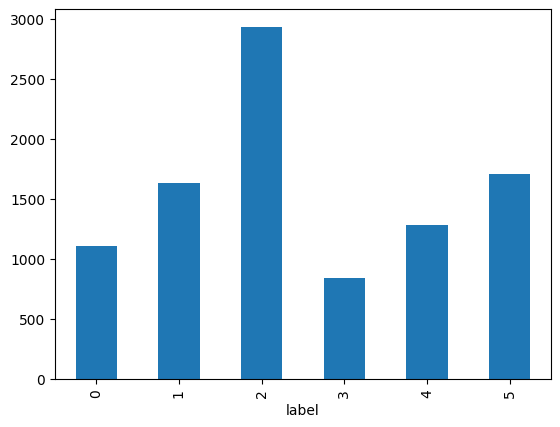

In [ ]:
# oversample fear and surprise
fear_df = df_audio[df_audio['label'].isin([3])]
for i in range(20):
    df_audio = pd.concat([df_audio, fear_df], ignore_index=True)

sur_df = df_audio[df_audio['label'].isin([4])]
for i in range(11):
    df_audio = pd.concat([df_audio, sur_df], ignore_index=True)



# Group the data by the 'label' column
label_groups = df_audio.groupby('label')

# Count the number of transcriptions in each group
transcription_counts = label_groups['wav_file'].count()

# Plot the counts as a bar chart with the y-axis starting at 0
ax = transcription_counts.plot(kind='bar', ylim=(0))

df_audio.to_csv('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/IEMOCAP_full_release/preprocesseddata/oversampling_audio_features.csv')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}




scalar = MinMaxScaler()
df_audio[df_audio.columns[2:]] = scalar.fit_transform(df_audio[df_audio.columns[2:]])
df_audio.head()

,wav_file,label,sig_mean,sig_std,rmse_mean,rmse_std,silence,harmonic,auto_corr_max,auto_corr_std
0,Ses01M_script02_1_F001,2,0.019368,0.031179,0.019496,0.055775,0.574933,0.228740,0.001440,0.000142
1,Ses01M_script02_1_F002,4,0.024850,0.041019,0.027618,0.070081,0.753255,0.228730,0.002389,0.000208
2,Ses01M_script02_1_F005,0,0.099805,0.123782,0.106320,0.159666,0.323432,0.228861,0.017251,0.003627
3,Ses01M_script02_1_F007,5,0.027278,0.036102,0.029279,0.050657,0.420000,0.229686,0.001837,0.000098
4,Ses01M_script02_1_F008,5,0.008010,0.009314,0.008396,0.011286,0.000000,0.228431,0.000119,0.000011


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(df_audio, test_size=0.20)

x_train.to_csv('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/IEMOCAP_full_release/preprocesseddata/audio_train.csv', index=False)
x_test.to_csv('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/IEMOCAP_full_release/preprocesseddata/audio_test.csv', index=False)

print(x_train.shape, x_test.shape)

(7603, 10) (1901, 10)


In [ ]:
x_train = pd.read_csv('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/IEMOCAP_full_release/preprocesseddata/audio_train.csv')
x_test = pd.read_csv('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/IEMOCAP_full_release/preprocesseddata/audio_test.csv')

print(x_train.shape)
y_train = x_train['label']
y_test = x_test['label']

(7603, 10)


In [ ]:
print(x_train)

                    wav_file  label  sig_mean   sig_std  rmse_mean  rmse_std  \
0       Ses03M_impro08a_F013      0  0.016785  0.020385   0.017664  0.026610   
1        Ses03F_impro08_F014      5  0.009521  0.012012   0.010425  0.015645   
2        Ses02F_impro03_F012      1  0.066338  0.075491   0.069019  0.082112   
3        Ses02F_impro03_F000      1  0.114004  0.138367   0.120451  0.173276   
4     Ses02F_script02_2_F034      2  0.015014  0.020785   0.015574  0.033232   
...                      ...    ...       ...       ...        ...       ...   
7598  Ses02M_script03_2_F007      5  0.024472  0.027890   0.025221  0.032534   
7599  Ses01F_script01_1_F002      4  0.019944  0.028969   0.021025  0.047235   
7600  Ses01M_script01_3_F026      2  0.014895  0.020557   0.015470  0.032735   
7601     Ses01F_impro03_M002      4  0.104301  0.139171   0.108447  0.205988   
7602  Ses01F_script01_3_M033      2  0.020195  0.030813   0.021531  0.051710   

       silence  harmonic  auto_corr_max

# Models

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=25)
rf_classifier.fit(x_train.iloc[:, 2:], y_train)

# Predict
# pred_probs = rf_classifier.predict_proba(x_test)
y_predict_lr3 = rf_classifier.predict(x_test.iloc[:, 2:])


print('Accuracy Score:', accuracy_score(y_test, y_predict_lr3))

class_report=classification_report(y_test, y_predict_lr3)
print(class_report)

# with open('pred_probas/rf_classifier.pkl', 'wb') as f:
#     pickle.dump(pred_probs, f)

Accuracy Score: 0.5686480799579169
              precision    recall  f1-score   support

           0       0.43      0.35      0.39       206
           1       0.42      0.19      0.26       332
           2       0.48      0.72      0.58       587
           3       0.99      1.00      0.99       169
           4       0.88      1.00      0.94       251
           5       0.42      0.29      0.34       356

    accuracy                           0.57      1901
   macro avg       0.60      0.59      0.58      1901
weighted avg       0.55      0.57      0.54      1901



In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
C = np.array(confusion_matrix(y_test, y_predict_lr3))

confmtrx = pd.DataFrame(C, index=['angry, true','happy, true','sad, true','fear, true','sur, true','neutral, true'],
                        columns=['angry, predicted','happy, predicted','sad, predicted','fear, predicted','sur, predicted','neutral, predicted'])

confmtrx.loc['sum'] = confmtrx.sum()
confmtrx['sum'] = confmtrx.sum(axis=1)
confmtrx

,"angry, predicted","happy, predicted","sad, predicted","fear, predicted","sur, predicted","neutral, predicted",sum
"angry, true",72,24,91,1,4,14,206
"happy, true",41,64,160,0,7,60,332
"sad, true",40,43,422,1,11,70,587
"fear, true",0,0,0,169,0,0,169
"sur, true",0,0,0,0,251,0,251
"neutral, true",13,22,206,0,12,103,356
sum,166,153,879,171,285,247,1901


AUC for class ang: 0.6470286679840765
AUC for class hap: 0.5680235281470047
AUC for class sad: 0.6855583559569464
AUC for class fea: 0.9994226327944572
AUC for class sur: 0.9896969696969696
AUC for class neu: 0.5980609796007418


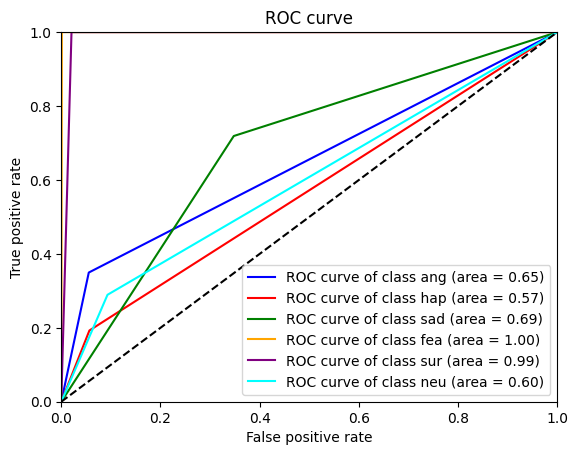

In [ ]:
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# Define class names
class_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']

# Convert y_predict_lr3 to a one-hot encoded format
n_classes = len(class_names)
y_pred_one_hot = np.zeros((y_predict_lr3.size, n_classes))
y_pred_one_hot[np.arange(y_predict_lr3.size), y_predict_lr3.astype(int)] = 1

# Initialize lists to store false positive rates, true positive rates, and AUCs
fprs = []
tprs = []
aucs = []

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    # Compute the ROC curve and AUC for the i-th class
    fpr, tpr, _ = metrics.roc_curve(y_test == i, y_pred_one_hot[:, i])
    auc = metrics.auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc)
    print(f"AUC for class {class_names[i]}: {auc}")

# Plotting the ROC curves
colors = ['blue', 'red', 'green', 'orange', 'purple', 'cyan']
plt.figure()

for i in range(n_classes):
    plt.plot(fprs[i], tprs[i], color=colors[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], aucs[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()


## MultinomialNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

multinaivebayes_classifier = MultinomialNB()

multinaivebayes_classifier.fit(x_train.iloc[:, 2:], y_train)

y_predict_lr4 = multinaivebayes_classifier.predict(x_test.iloc[:, 2:])

print('Accuracy Score:', accuracy_score(y_test, y_predict_lr4))

#Create classification report
class_report2=classification_report(y_test, y_predict_lr4,zero_division=True)
print(class_report2)

Accuracy Score: 0.3103629668595476
              precision    recall  f1-score   support

           0       0.33      0.03      0.05       206
           1       1.00      0.00      0.00       332
           2       0.31      0.99      0.47       587
           3       1.00      0.00      0.00       169
           4       1.00      0.00      0.00       251
           5       1.00      0.00      0.00       356

    accuracy                           0.31      1901
   macro avg       0.77      0.17      0.09      1901
weighted avg       0.71      0.31      0.15      1901



In [ ]:
C = np.array(confusion_matrix(y_test, y_predict_lr4))

confmtrx = pd.DataFrame(C, index=['angry, true','happy, true','sad, true','fear, true','sur, true','neutral, true'],
                        columns=['angry, predicted','happy, predicted','sad, predicted','fear, predicted','sur, predicted','neutral, predicted'])

confmtrx.loc['sum'] = confmtrx.sum()
confmtrx['sum'] = confmtrx.sum(axis=1)
confmtrx

,"angry, predicted","happy, predicted","sad, predicted","fear, predicted","sur, predicted","neutral, predicted",sum
"angry, true",6,0,200,0,0,0,206
"happy, true",5,0,327,0,0,0,332
"sad, true",3,0,584,0,0,0,587
"fear, true",0,0,169,0,0,0,169
"sur, true",3,0,248,0,0,0,251
"neutral, true",1,0,355,0,0,0,356
sum,18,0,1883,0,0,0,1901


## Logistic Regression

In [ ]:
logisticreg_classifer = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000)
logisticreg_classifer.fit(x_train.iloc[:,2:], y_train)

y_predict_lr5 = logisticreg_classifer.predict(x_test.iloc[:,2:])

print('Accuracy Score:', accuracy_score(y_test, y_predict_lr5))

#Create classification report
class_report3=classification_report(y_test, y_predict_lr5,zero_division=True)
print(class_report3)

Accuracy Score: 0.3235139400315623
              precision    recall  f1-score   support

           0       0.37      0.22      0.28       206
           1       0.30      0.04      0.07       332
           2       0.32      0.95      0.48       587
           3       1.00      0.00      0.00       169
           4       1.00      0.00      0.00       251
           5       1.00      0.00      0.00       356

    accuracy                           0.32      1901
   macro avg       0.67      0.20      0.14      1901
weighted avg       0.60      0.32      0.19      1901



## XGBoost

In [ ]:
import xgboost
model_xgb = xgboost.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob',
                                   n_estimators=600, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
model_xgb.fit(x_train.iloc[:,2:], y_train)

y_predict_lr6 = model_xgb.predict(x_test.iloc[:,2:])

print('Accuracy Score:', accuracy_score(y_test, y_predict_lr6))

class_report4=classification_report(y_test, y_predict_lr6)
print(class_report4)

Accuracy Score: 0.5507627564439769
              precision    recall  f1-score   support

           0       0.40      0.33      0.37       206
           1       0.36      0.20      0.25       332
           2       0.47      0.70      0.56       587
           3       0.97      1.00      0.98       169
           4       0.92      0.95      0.93       251
           5       0.39      0.27      0.32       356

    accuracy                           0.55      1901
   macro avg       0.58      0.57      0.57      1901
weighted avg       0.53      0.55      0.53      1901



AUC for class ang: 0.6370922473293811
AUC for class hap: 0.5602879971127339
AUC for class sad: 0.6753368908802854
AUC for class fea: 0.9982678983833718
AUC for class sur: 0.9694289508632139
AUC for class neu: 0.585530526162685


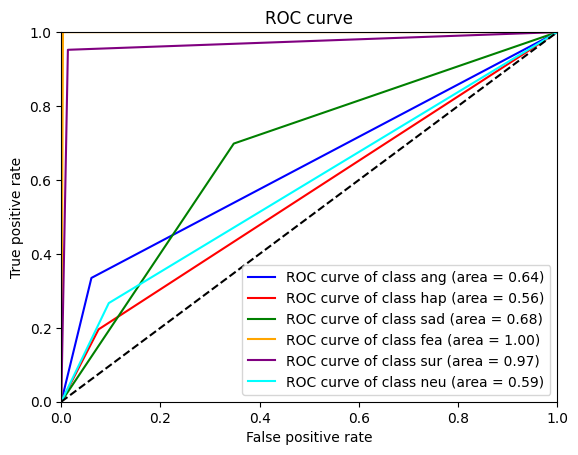

In [ ]:
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# Define class names
class_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']

# Convert y_predict_lr3 to a one-hot encoded format
n_classes = len(class_names)
y_pred_one_hot = np.zeros((y_predict_lr6.size, n_classes))
y_pred_one_hot[np.arange(y_predict_lr6.size), y_predict_lr6.astype(int)] = 1

# Initialize lists to store false positive rates, true positive rates, and AUCs
fprs = []
tprs = []
aucs = []

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    # Compute the ROC curve and AUC for the i-th class
    fpr, tpr, _ = metrics.roc_curve(y_test == i, y_pred_one_hot[:, i])
    auc = metrics.auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc)
    print(f"AUC for class {class_names[i]}: {auc}")

# Plotting the ROC curves
colors = ['blue', 'red', 'green', 'orange', 'purple', 'cyan']
plt.figure()

for i in range(n_classes):
    plt.plot(fprs[i], tprs[i], color=colors[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], aucs[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()


In [ ]:
C = np.array(confusion_matrix(y_test, y_predict_lr6))

confmtrx = pd.DataFrame(C, index=['angry, true','happy, true','sad, true','fear, true','sur, true','neutral, true'],
                        columns=['angry, predicted','happy, predicted','sad, predicted','fear, predicted','sur, predicted','neutral, predicted'])

confmtrx.loc['sum'] = confmtrx.sum()
confmtrx['sum'] = confmtrx.sum(axis=1)
confmtrx

,"angry, predicted","happy, predicted","sad, predicted","fear, predicted","sur, predicted","neutral, predicted",sum
"angry, true",69,39,79,1,2,16,206
"happy, true",36,65,161,3,8,59,332
"sad, true",48,50,410,1,5,73,587
"fear, true",0,0,0,169,0,0,169
"sur, true",0,4,8,0,239,0,251
"neutral, true",19,25,209,1,7,95,356
sum,172,183,867,175,261,243,1901
